This notebook illustrates how to compute the Imbalance Gain measure described in "Robust inference of causality in high-dimensional dynamical processes from the Information Imbalance of distance ranks" (V. Del Tatto, G. Fortunato, D. Bueti, A. Laio, https://arxiv.org/abs/2305.10817), using the illustrative example two Rössler systems coupled in direction $X\,\rightarrow\,Y$. The trajectory was generated by integrating the equations
\begin{aligned}
    &\dot{x}_{1}(t)=-\omega_{1}\, x_{2}(t)-x_{3}(t) \\
    &\dot{x}_{2}(t)=\omega_{1}\, x_{1}(t)+0.15\, x_{2}(t) \\
    &\dot{x}_{3}(t)=0.2+x_{3}(t)\left[x_{1}(t)-10\right] \\
    &\dot{y}_{1}(t)=-\omega_{2}\, y_{2}(t)-y_{3}(t)+\epsilon\left[x_{1}(t)-y_{1}(t)\right] \\
    &\dot{y}_{2}(t)=\omega_{2}\, y_{1}(t)+0.15 y_{2}(t) \\
    &\dot{y}_{3}(t)=0.2+y_{3}(t)\left[y_{1}(t)-10\right]
\end{aligned}
where $\omega_1=1.015,\,\omega_2=0.985$ and $\epsilon = 0.07$. The system is integrated using the "dop853" (Dormand-Price) solver for the scipy class integrate.ode. Step size is set to 0.0785, downsampling data to each fourth giving the sampling step 0.0785 $\times$ 4 = 0.314. The first system is initialized using coordinates from the Rossler attractor (11.120979, 17.496796, 51.023544), for the second these values are multiplied by a random number between 0.5 and 1.5.

In [1]:
import numpy as np
from utilities import *
from imbalance_gain import *
import matplotlib.pyplot as plt
import pickle

Let's start by loading the trajectory and plotting a chunk of 200 points:

In [2]:
trajectory = pickle.load(open("data/test_trajectory.p", "rb"))
traj_length = trajectory.shape[0]
print(f"Number of time points: {trajectory.shape[0]}")
print(f"Number of components: {trajectory.shape[1]}") # first component is time

Number of time points: 105001
Number of components: 7


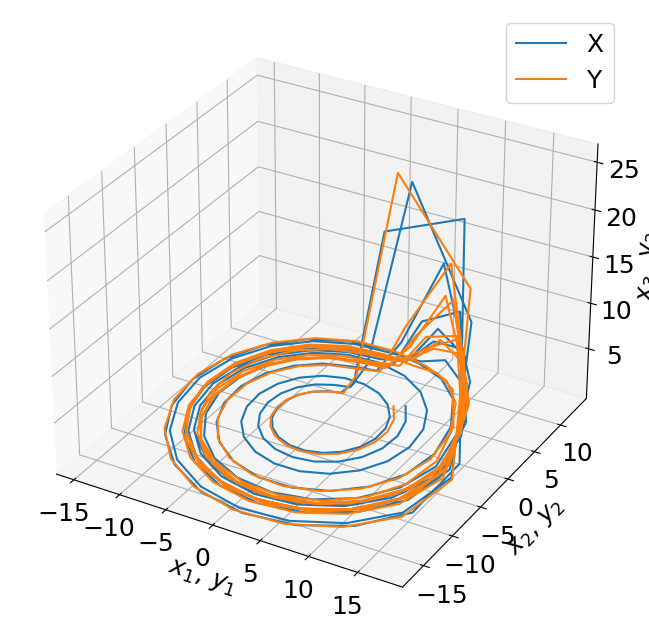

In [3]:
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

start_plot = 5000
end_plot = 5200

x_1 = trajectory[start_plot:end_plot,1]
x_2 = trajectory[start_plot:end_plot,2]
x_3 = trajectory[start_plot:end_plot,3]
y_1 = trajectory[start_plot:end_plot,4]
y_2 = trajectory[start_plot:end_plot,5]
y_3 = trajectory[start_plot:end_plot,6]

ax.plot3D(x_1, x_2, x_3, label="X")
ax.plot3D(y_1, y_2, y_3, label="Y")

ax.set_xlabel("$x_1,\,y_1$")
ax.set_ylabel("$x_2,\,y_2$")
ax.set_zlabel("$x_3,\,y_3$")

ax.legend()
plt.show()

# 1) Causality test using all coordinates
The method tries to assess the presence of the coupling in the $X\rightarrow Y$ direction by computing the Imbalance Gain
\begin{equation}
    \delta \Delta := \frac{\Delta(\alpha=0) - \min_\alpha \Delta(\alpha)}{\Delta(\alpha=0)}\,,
\end{equation}
where $\Delta(\alpha) := \Delta((\alpha\,X(t),\,Y(t))\rightarrow Y(t + \tau))$. The opposite direction $Y\rightarrow X$ can be studied exchanging the roles of $X$ and $Y$.

The parameters of the methods are
- $N$: number of independent trajectories extracted
- $\tau$: time lag between "past" and "future"
- $k$: number of nearest neighbors to compute the Information Imbalance 
- $\{\alpha_i\}$: values scanned to optimize the Imbalance Gain 

In [4]:
tau = 20
N = 2500
sample_times = np.linspace(5000,traj_length-tau-1,N,dtype=int)
k = 5
alphas = np.linspace(0,1,50)
n_jobs = 4 #parallelize the calculation for different alphas

Let's compute $\Delta(\alpha)$ in both directions using the functions provided in this repository (https://github.com/vdeltatto/imbalance-gain-causality):

In [5]:
X0 = trajectory[sample_times,1:4]
Y0 = trajectory[sample_times,4:]
rank_matrix_Xtau = compute_rank_matrix(trajectory[sample_times + tau,1:4])
rank_matrix_Ytau = compute_rank_matrix(trajectory[sample_times + tau,4:])

info_imbalances_X_to_Y = scan_alphas(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
info_imbalances_Y_to_X = scan_alphas(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")

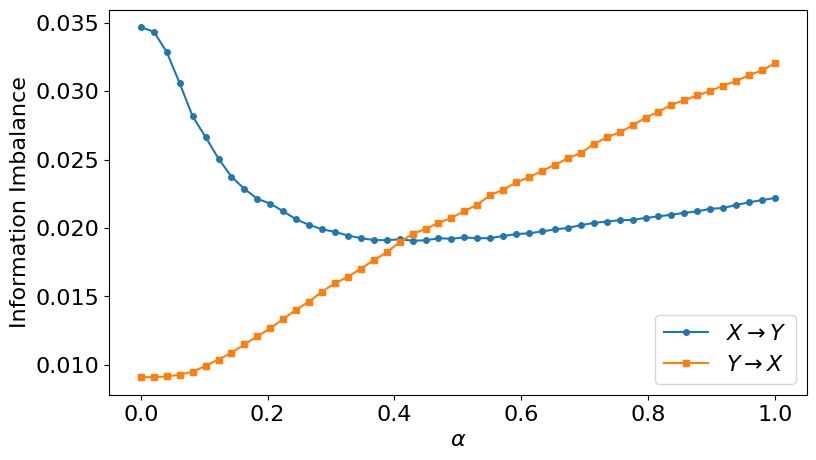

In [6]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=4, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 's-', markersize=4, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

In [7]:
imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y = compute_imbalance_gain(info_imbalances_X_to_Y)
imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X = compute_imbalance_gain(info_imbalances_Y_to_X)

print("Imbalance Gain X -> Y: {:.2f} %".format(100*imbalance_gain_X_to_Y))
print("Imbalance Gain Y -> X: {:.2f} %".format(100*imbalance_gain_Y_to_X))

print("Optimal alpha X -> Y: {:.2f}".format(alphas[index_optimal_alpha_X_to_Y]))
print("Optimal alpha Y -> X: {:.2f}".format(alphas[index_optimal_alpha_Y_to_X]))

Imbalance Gain X -> Y: 44.99 %
Imbalance Gain Y -> X: 0.06 %
Optimal alpha X -> Y: 0.43
Optimal alpha Y -> X: 0.02


The Imbalance Gains clearly detect a unidirectional coupling $X\rightarrow Y$.

Alternatively, the same results can be obatined using the function 'return_inf_imb_causality' of the 'MetricComparisons' class in the Python package DADApy (https://github.com/sissa-data-science/DADApy):

In [8]:
from dadapy.metric_comparisons import MetricComparisons

X0 = trajectory[sample_times,1:4]
Y0 = trajectory[sample_times,4:]
Xtau = trajectory[sample_times+tau,1:4]
Ytau = trajectory[sample_times+tau,4:]

d = MetricComparisons(maxk=len(sample_times)-1, n_jobs=n_jobs)
info_imbalances_X_to_Y = d.return_inf_imb_causality(cause_present=X0, effect_present=Y0, effect_future=Ytau, weights=alphas, k=k)
info_imbalances_Y_to_X = d.return_inf_imb_causality(cause_present=Y0, effect_present=X0, effect_future=Xtau, weights=alphas, k=k)

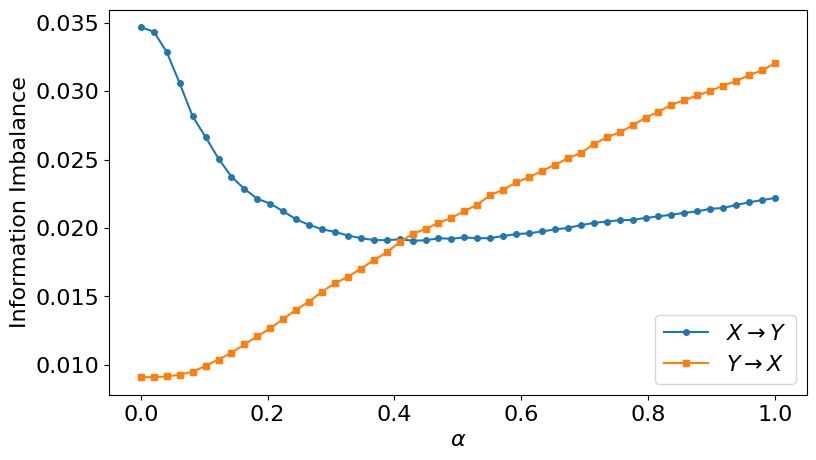

In [9]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=4, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 's-', markersize=4, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

# 2) Causality test using time-delay embeddings
If we only recorded variables $x_1$ for system $X$ and $y_1$ for system $Y$, we can still apply the method on the time-delay embedding representations of these variables, namely 
\begin{aligned}
    \widetilde{x}(t) &= (x_1(t),\,x_1(t-\tau_e),...,\,x_1(t-(E-1)\tau_e)) \in M_{x_1}\,, \\
    \widetilde{y}(t) &= (y_1(t),\,y_1(t-\tau_e),...,\,y_1(t-(E-1)\tau_e)) \in M_{y_1}\,,
\end{aligned}
where we consider here for simplicity the same embedding parameters $\tau_e$ and $E$ for $x_1$ and $y_1$.

In [10]:
E = 3
tau_e = 1
traj_length = trajectory.shape[0] - tau_e*E

X_time_delay = construct_time_delay_embedding(trajectory[:,1], E=E, tau_e=tau_e)
Y_time_delay = construct_time_delay_embedding(trajectory[:,4], E=E, tau_e=tau_e)
print(X_time_delay.shape, Y_time_delay.shape)

(104998, 3) (104998, 3)


Let's plot the trajectory in the "shadow manifolds" $M_{x_1}$ and $M_{y_1}$:

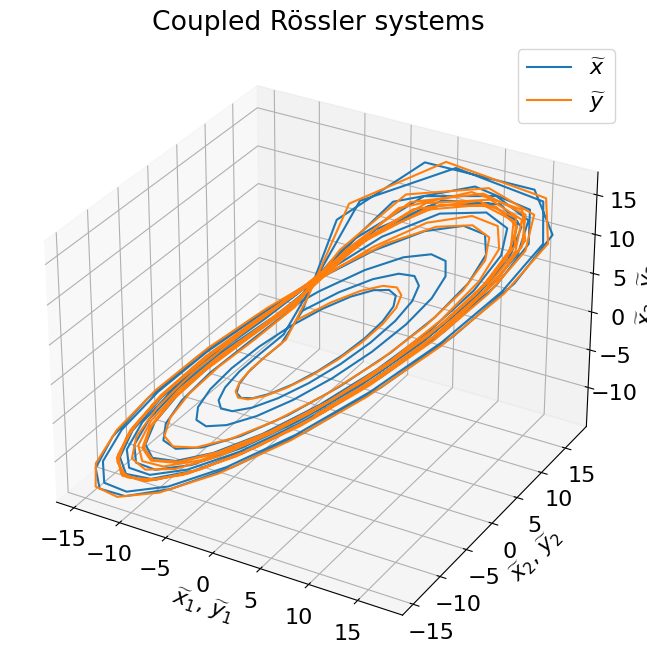

In [11]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

start_plot = 5000
end_plot = 5200

x_1 = X_time_delay[start_plot:end_plot,0]
x_2 = X_time_delay[start_plot:end_plot,1]
x_3 = X_time_delay[start_plot:end_plot,2]
y_1 = Y_time_delay[start_plot:end_plot,0]
y_2 = Y_time_delay[start_plot:end_plot,1]
y_3 = Y_time_delay[start_plot:end_plot,2]

ax.plot3D(x_1, x_2, x_3, label="$\\widetilde{x}$")
ax.plot3D(y_1, y_2, y_3, label="$\\widetilde{y}$")

ax.set_title("Coupled Rössler systems")
ax.set_xlabel("$\\widetilde{x}_1,\,\\widetilde{y}_1$")
ax.set_ylabel("$\\widetilde{x}_2,\,\\widetilde{y}_2$")
ax.set_zlabel("$\\widetilde{x}_3,\,\\widetilde{y}_3$")

ax.legend()
plt.show()

We set again the parameters to compute $\Delta(\alpha)$ in both directions:

In [12]:
tau = 20
N = 2500
sample_times = np.linspace(5000,traj_length-tau-1,N,dtype=int)
alphas = np.linspace(0,1,50)
k = 5
n_jobs = 4

In [13]:
X0 = X_time_delay[sample_times]
Y0 = Y_time_delay[sample_times]
rank_matrix_Xtau = compute_rank_matrix(X_time_delay[sample_times + tau])
rank_matrix_Ytau = compute_rank_matrix(Y_time_delay[sample_times + tau])

# alternative, more efficient for memory storage in case of long and high-dimensional trajectories:
#X0, Y0 = construct_time_delay_embedding(X=trajectory[:,1], Y=trajectory[:,4],
#                                        E=E, tau_e=tau_e, sample_times=sample_times)
#Xtau, Ytau = construct_time_delay_embedding(X=trajectory[:,1], Y=trajectory[:,4],
#                                        E=E, tau_e=tau_e, sample_times=sample_times+tau)
#rank_matrix_Xtau = compute_rank_matrix(Xtau)
#rank_matrix_Ytau = compute_rank_matrix(Ytau)

info_imbalances_X_to_Y = scan_alphas(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
info_imbalances_Y_to_X = scan_alphas(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")

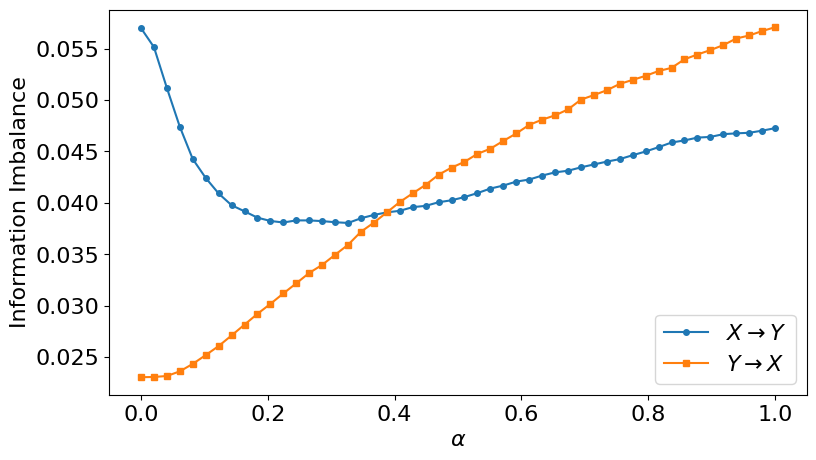

In [14]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=4, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 's-', markersize=4, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

Let's compute the Imbalance Gains:

In [15]:
imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y = compute_imbalance_gain(info_imbalances_X_to_Y)
imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X = compute_imbalance_gain(info_imbalances_Y_to_X)

print("Imbalance Gain X -> Y: {:.2f} %".format(100*imbalance_gain_X_to_Y))
print("Imbalance Gain Y -> X: {:.2f} %".format(100*imbalance_gain_Y_to_X))

print("Optimal alpha X -> Y: {:.2f}".format(alphas[index_optimal_alpha_X_to_Y]))
print("Optimal alpha Y -> X: {:.2f}".format(alphas[index_optimal_alpha_Y_to_X]))

Imbalance Gain X -> Y: 33.24 %
Imbalance Gain Y -> X: 0.00 %
Optimal alpha X -> Y: 0.33
Optimal alpha Y -> X: 0.00


Using time-delay embeddings the metohd still identifies a unidirectional coupling $X\rightarrow Y$.

Also in this case we can obtain the same results using DADApy:

In [16]:
X0 = X_time_delay[sample_times]
Y0 = Y_time_delay[sample_times]
Xtau = X_time_delay[sample_times+tau]
Ytau = Y_time_delay[sample_times+tau]

d = MetricComparisons(maxk=len(sample_times)-1, n_jobs=n_jobs)
info_imbalances_X_to_Y = d.return_inf_imb_causality(cause_present=X0, effect_present=Y0, effect_future=Ytau, weights=alphas, k=k)
info_imbalances_Y_to_X = d.return_inf_imb_causality(cause_present=Y0, effect_present=X0, effect_future=Xtau, weights=alphas, k=k)

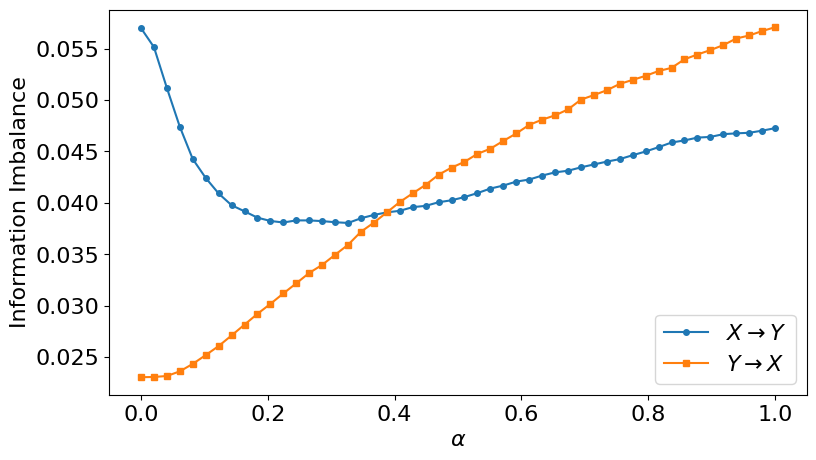

In [17]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=4, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 's-', markersize=4, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

# 3) Testing different values of $\tau$
Computing the Information Imbalance $\Delta(Y(0)\rightarrow Y(\tau))$ as a function of the time lag $\tau$ can help to choose the values of the time lag to be tested in the causality test, when also $X(0)$ is included. The values of $\tau$ that can be meaningfully tested by means of the Imbalance Gain are the ones for which $\Delta(Y(0)\rightarrow Y(\tau)) < 1$. The Information Imbalance can be computed in DADApy with the method 'return_inf_imb_two_selected_coords' of the 'MetricComparisons' class. For a detailed tutorial on the Information Imbalance measure, see https://dadapy.readthedocs.io/en/latest/jupyter_example_2.html.

In [18]:
taus = np.arange(-100,105,5)
N = 2500
sample_times = np.linspace(5000,traj_length-taus[-1]-1,N,dtype=int)
alphas = np.linspace(0,1,50)
k = 5
n_jobs = 4

In [20]:
Deltas_Y0_to_Ytau = np.zeros((len(taus),2))

Y0 = trajectory[sample_times,4:]
for i_tau, tau in enumerate(taus):
    Ytau = trajectory[sample_times+tau,4:]
    d = MetricComparisons(np.column_stack((Y0,Ytau)), maxk=Y0.shape[0]-1, n_jobs=n_jobs)
    Deltas_Y0_to_Ytau[i_tau] = d.return_inf_imb_two_selected_coords(coords1=np.arange(Y0.shape[1]),
                                                                    coords2=np.arange(Y0.shape[1], 2*Y0.shape[1]),
                                                                    k=k)

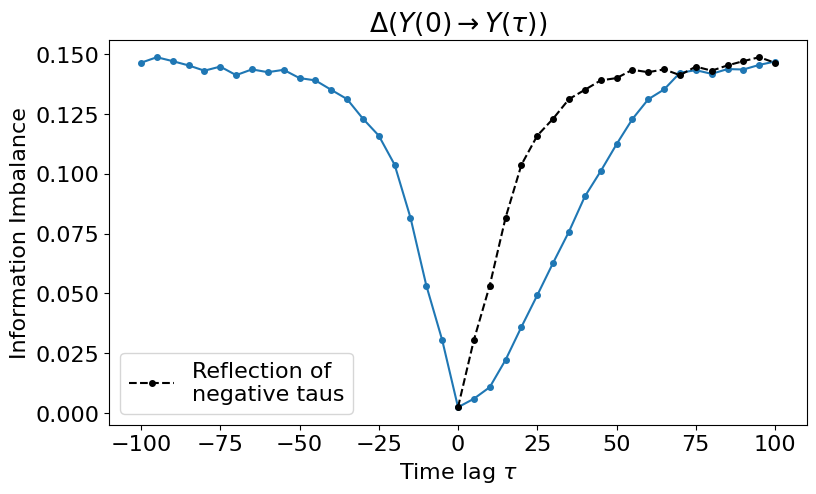

In [21]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(taus, Deltas_Y0_to_Ytau[:,0], 'o-', markersize=4)
plt.plot(taus[len(taus)//2:], np.flip(Deltas_Y0_to_Ytau[:len(taus)//2+1,0]), '--o', 
         markersize=4, color="black", label="Reflection of\nnegative taus")
plt.xlabel("Time lag $\\tau $")
plt.ylabel("Information Imbalance")
plt.title("$\Delta(Y(0)\\rightarrow Y(\\tau))$")
plt.legend()
plt.show()